# Analyzing TCR data
![dandelion_logo](img/dandelion_logo_illustration.png)

With `dandelion>=1.3` onwards, there will be the ability to start analyzing 10x single-cell TCR data with the existing setup for both alpha-beta and gamma-delta TCR data formats. Currently, the alpha-beta and gamma-delta data sets have to be analyzed separately.

The workflow may be a bit buggy because it's not optimised for TCR data; do let me know if you find any bugs and I can see if i can try to fix the issue(s).

We will download the various input formats of TCR files from 10x as part of this tutorial:

```bash
# bash
mkdir -p dandelion_tutorial/sc5p_v2_hs_T_1k_multi_5gex_t
cd dandelion_tutorial/sc5p_v2_hs_T_1k_multi_5gex_t
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_T_1k_multi_5gex_t/sc5p_v2_hs_T_1k_multi_5gex_t_vdj_t_airr_rearrangement.tsv
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_T_1k_multi_5gex_t/sc5p_v2_hs_T_1k_multi_5gex_t_count_filtered_feature_bc_matrix.h5
cd ..

mkdir sc5p_v2_hs_PBMC_10k
cd sc5p_v2_hs_PBMC_10k
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_all_contig_annotations.json
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.tar.gz
cd ..

mkdir sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t
cd sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t/sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t_vdj_t_filtered_contig_annotations.csv
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t/sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t_count_filtered_feature_bc_matrix.h5
cd ..
```

**Import *dandelion* module**

In [2]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_versions()

dandelion==0.1.3.dev33 pandas==1.2.3 numpy==1.20.1 matplotlib==3.3.4 networkx==2.5 scipy==1.6.1 skbio==0.5.6


**Read in files**

In [3]:
# read in the airr_rearrangement.tsv file
file1 = 'sc5p_v2_hs_T_1k_multi_5gex_t/sc5p_v2_hs_T_1k_multi_5gex_t_vdj_t_airr_rearrangement.tsv'
file2 = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_all_contig_annotations.json'
file3 = 'sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t/sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t_vdj_t_filtered_contig_annotations.csv'

In [4]:
vdj1 = ddl.read_10x_airr(file1)
vdj1

Dandelion class object with n_obs = 1018 and n_contigs = 2064
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary', 'VDJ_chain_s

To read the other two formats, we make use of `scirpy`'s `ir.io.read_10x_vdj` to read the files in.

However, doing so will lose some information like the full V(D)J sequence alignment but that's up to your preference.

The preferred way to read TCR data into dandelion is via the AIRR format.

In [5]:
vdj2 = ddl.read_10x_vdj(file2)
vdj2

Dandelion class object with n_obs = 5286 and n_contigs = 13553
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'consensus_count', 'locus', 'np1_length', 'np2_length', 'cell_id', 'multi_chain', 'is_cell', 'high_confidence', 'umi_count', 'duplicate_count'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VDJ_2', 'duplicate_count_VDJ_3', 'duplicate_count_VDJ_4', 'duplicate_count_VDJ_5', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'duplicate_count_VJ_2', 'duplicate_count_VJ_3', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary', 'VDJ_chain_status_s

In [6]:
vdj3 = ddl.read_10x_vdj(file3)
vdj3

Dandelion class object with n_obs = 5215 and n_contigs = 10789
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'consensus_count', 'locus', 'cell_id', 'multi_chain', 'is_cell', 'high_confidence', 'umi_count', 'duplicate_count'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary', 'VDJ_chain_status_summary'
    distance: None
    edges: None
    layout: None
    graph: None

**examine the AIRR formatted tables.**

In [7]:
vdj1.data

,cell_id,clone_id,sequence_id,sequence,sequence_aa,productive,rev_comp,v_call,v_cigar,d_call,...,d_sequence_start,d_sequence_end,j_sequence_start,j_sequence_end,c_sequence_start,c_sequence_end,consensus_count,duplicate_count,is_cell,locus
sequence_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGTTACCCA-1_contig_1,AAACCTGAGTTACCCA-1,NaN,AAACCTGAGTTACCCA-1_contig_1,TTTTGAAACCCTTCAAAGGCAGAGACTTGTCCAGCCTAACCTGCCT...,MLLLLVPVLEVIFTLGGTRAQSVTQLGSHVSVSEGALVLLRCNYSS...,T,F,TRAV8-4,128S341M101S,NaN,...,NaN,NaN,466,528,529.0,570.0,2608,9,T,TRA
AAACCTGAGTTACCCA-1_contig_2,AAACCTGAGTTACCCA-1,NaN,AAACCTGAGTTACCCA-1_contig_2,AGAGGCCCCATCTCAGACCCGAGGCTAGCATGGGCTGCAGGCTGCT...,MGCRLLCCAVLCLLGAVPMETGVTQTPRHLVMGMTNKKSLKCEQHL...,T,F,TRBV4-3,29S344M108S,NaN,...,NaN,NaN,381,429,430.0,481.0,8085,16,T,TRB
AAACCTGAGTTACCCA-1_contig_3,AAACCTGAGTTACCCA-1,NaN,AAACCTGAGTTACCCA-1_contig_3,GAGAAGCCTCACACAGCCCAGTAACTTTGCTAGTACCTCTTGAGTG...,MLTASLLRAVIASICVVSSMAQKVTQAQTEISVVEKEDVTLDCVYE...,T,F,TRAV19,117S350M104S,NaN,...,NaN,NaN,470,529,530.0,571.0,731,2,T,TRA
AAACCTGCAAGCTGAG-1_contig_1,AAACCTGCAAGCTGAG-1,NaN,AAACCTGCAAGCTGAG-1_contig_1,GGAAAAGCAAGGCTGAGAATTTAGCTCTTTCCCAGGAGGACCAAGC...,MGSRLLCWVLLCLLGAGPVKAGVTQTPRYLIKTRGQQVTLSCSPIS...,T,F,TRBV5-1,84S343M109S,NaN,...,NaN,NaN,434,484,485.0,536.0,6295,12,T,TRB
AAACCTGCAAGCTGAG-1_contig_2,AAACCTGCAAGCTGAG-1,NaN,AAACCTGCAAGCTGAG-1_contig_2,AGATCAGAAGAGGAGGCTTCTCACCCTGCAGCAGGGACCTGTGAGC...,MACPGFLWALVISTCLEFSMAQTVTQSQPEMSVQEAETVTLSCTYD...,T,F,TRAV38-2/DV8,46S349M96S,NaN,...,NaN,NaN,395,449,450.0,491.0,2139,5,T,TRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTCTGCAAT-1_contig_1,TTTGTCAGTCTGCAAT-1,NaN,TTTGTCAGTCTGCAAT-1_contig_1,AGACCAGAATCCTGCCCTGGGCCTTGCCTGGTCTGCCTCACTCTGC...,MGCRLLCCVVFCLLQAGPLDTAVSQTPKYLVTQMGNDKSIKCEQNL...,T,F,TRBV3-1,47S344M117S,TRBD1,...,391.0,402.0,409,456,457.0,508.0,3800,11,T,TRB
TTTGTCAGTCTGCAAT-1_contig_2,TTTGTCAGTCTGCAAT-1,NaN,TTTGTCAGTCTGCAAT-1_contig_2,TTTTGAAACCCTTCAAAGGCAGAGACTTGTCCAGCCTAACCTGCCT...,MLLLLVPVLEVIFTLGGTRAQSVTQLGSHVSVSEGALVLLRCNYSS...,T,F,TRAV8-4,128S341M101S,NaN,...,NaN,NaN,473,528,529.0,570.0,1795,6,T,TRA
TTTGTCAGTTAAGACA-1_contig_1,TTTGTCAGTTAAGACA-1,NaN,TTTGTCAGTTAAGACA-1_contig_1,ACAGTGATCCTGATCTGGTAAAGCTCCCATCCTGCCCTGACCCTGC...,MGTRLLFWVAFCLLGADHTGAGVSQSPSNKVTEKGKDVELRCDPIS...,T,F,TRBV7-2,47S347M108S,NaN,...,NaN,NaN,404,450,451.0,502.0,11967,23,T,TRB


In [8]:
vdj2.data

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,consensus_count,locus,np1_length,np2_length,cell_id,multi_chain,is_cell,high_confidence,umi_count,duplicate_count
sequence_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGCGATAGC-1_contig_1,AAACCTGAGCGATAGC-1_contig_1,None,None,True,TRAV23/DV6,None,TRAJ22,None,None,TGTGCAGCAAGCAAGGGTTCTGCAAGGCAACTGACCTTT,...,2699.0,TRA,2.0,NaN,AAACCTGAGCGATAGC-1,False,True,True,11.0,11.0
AAACCTGAGCGATAGC-1_contig_2,AAACCTGAGCGATAGC-1_contig_2,None,None,True,TRBV6-5,None,TRBJ2-3,None,None,TGTGCCAGCAGTTACCGGGGGGGATCGGAAGATACGCAGTATTTT,...,3202.0,TRB,NaN,NaN,AAACCTGAGCGATAGC-1,False,True,True,9.0,9.0
AAACCTGAGTCACGCC-1_contig_1,AAACCTGAGTCACGCC-1_contig_1,None,None,True,TRAV8-6,None,TRAJ8,None,None,TGTGCTGTGAGTGCGTTTTTTCAGAAACTTGTATTT,...,983.0,TRA,4.0,NaN,AAACCTGAGTCACGCC-1,False,True,True,9.0,9.0
AAACCTGAGTCACGCC-1_contig_2,AAACCTGAGTCACGCC-1_contig_2,None,None,True,TRBV6-2,None,TRBJ2-6,None,None,TGTGCCAGCAGTTATCTCCCCCGTAGACAGGACAGGGAATCCTCTG...,...,4032.0,TRB,NaN,NaN,AAACCTGAGTCACGCC-1,False,True,True,12.0,12.0
AAACCTGCACGTCAGC-1_contig_1,AAACCTGCACGTCAGC-1_contig_1,None,None,True,TRAV1-2,None,TRAJ33,None,None,TGTGCTGTCATGGATAGCAACTATCAGTTAATCTGG,...,881.0,TRA,4.0,NaN,AAACCTGCACGTCAGC-1,False,True,True,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCTCTGAGA-1_contig_3,TTTGTCATCTCTGAGA-1_contig_3,None,None,True,TRBV11-2,None,TRBJ1-4,None,None,TGTGCCAGCAGCCAGACAGGGACCGAAAAACTGTTTTTT,...,4316.0,TRB,NaN,NaN,TTTGTCATCTCTGAGA-1,False,True,True,12.0,12.0
TTTGTCATCTCTGAGA-1_contig_4,TTTGTCATCTCTGAGA-1_contig_4,None,None,False,None,None,TRBJ2-3,None,None,None,...,3553.0,TRB,NaN,NaN,TTTGTCATCTCTGAGA-1,False,True,True,13.0,13.0
TTTGTCATCTTCGAGA-1_contig_1,TTTGTCATCTTCGAGA-1_contig_1,None,None,True,TRAV12-1,None,TRAJ9,None,None,TGTGTGGTGAACGGCGGGAGTACTGGAGGCTTCAAAACTATCTTT,...,1969.0,TRA,2.0,NaN,TTTGTCATCTTCGAGA-1,False,True,True,9.0,9.0


In [9]:
vdj3.data

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,j_cigar,c_call,consensus_count,locus,cell_id,multi_chain,is_cell,high_confidence,umi_count,duplicate_count
sequence_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGCGATAGC-1_contig_1,AAACCTGAGCGATAGC-1_contig_1,None,None,True,TRAV23/DV6,None,TRAJ22,None,None,TGTGCAGCAAGCAAGGGTTCTGCAAGGCAACTGACCTTT,...,None,TRAC,2699.0,TRA,AAACCTGAGCGATAGC-1,False,True,True,11.0,11.0
AAACCTGAGCGATAGC-1_contig_2,AAACCTGAGCGATAGC-1_contig_2,None,None,True,TRBV6-5,None,TRBJ2-3,None,None,TGTGCCAGCAGTTACCGGGGGGGATCGGAAGATACGCAGTATTTT,...,None,TRBC2,3202.0,TRB,AAACCTGAGCGATAGC-1,False,True,True,9.0,9.0
AAACCTGAGTCACGCC-1_contig_1,AAACCTGAGTCACGCC-1_contig_1,None,None,True,TRAV8-6,None,TRAJ8,None,None,TGTGCTGTGAGTGCGTTTTTTCAGAAACTTGTATTT,...,None,TRAC,983.0,TRA,AAACCTGAGTCACGCC-1,False,True,True,9.0,9.0
AAACCTGAGTCACGCC-1_contig_2,AAACCTGAGTCACGCC-1_contig_2,None,None,True,TRBV6-2,None,TRBJ2-6,None,None,TGTGCCAGCAGTTATCTCCCCCGTAGACAGGACAGGGAATCCTCTG...,...,None,TRBC2,4032.0,TRB,AAACCTGAGTCACGCC-1,False,True,True,12.0,12.0
AAACCTGCACGTCAGC-1_contig_1,AAACCTGCACGTCAGC-1_contig_1,None,None,True,TRAV1-2,None,TRAJ33,None,None,TGTGCTGTCATGGATAGCAACTATCAGTTAATCTGG,...,None,TRAC,881.0,TRA,AAACCTGCACGTCAGC-1,False,True,True,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCTCTGAGA-1_contig_1,TTTGTCATCTCTGAGA-1_contig_1,None,None,True,TRAV3,None,TRAJ22,None,None,TGTGCTGTGAGACTCTCAAGGCAACTGACCTTT,...,None,TRAC,2080.0,TRA,TTTGTCATCTCTGAGA-1,False,True,True,11.0,11.0
TTTGTCATCTCTGAGA-1_contig_2,TTTGTCATCTCTGAGA-1_contig_2,None,None,True,TRBV7-2,None,TRBJ1-2,None,None,TGTGCCAGCACCATTATGTCGGGGGCGGATGGCTATGGCTACACCTTC,...,None,TRBC1,4060.0,TRB,TTTGTCATCTCTGAGA-1,False,True,True,13.0,13.0
TTTGTCATCTCTGAGA-1_contig_3,TTTGTCATCTCTGAGA-1_contig_3,None,None,True,TRBV11-2,None,TRBJ1-4,None,None,TGTGCCAGCAGCCAGACAGGGACCGAAAAACTGTTTTTT,...,None,TRBC1,4316.0,TRB,TTTGTCATCTCTGAGA-1,False,True,True,12.0,12.0


For the purpose of the tutorial, we will just analyze one of the samples.

In [10]:
# let's add the sample_id to each cell barcode so that we don't end up overlapping later on
sample_id = 'sc5p_v2_hs_T_1k_multi_5gex_t'
vdj1.data['sample_id'] = sample_id
vdj1.data['cell_id'] = [sample_id + '_' + c for c in vdj1.data['cell_id']]
vdj1.data['sequence_id'] = [sample_id + '_' + s for s in vdj1.data['sequence_id']]

sample_id = 'sc5p_v2_hs_PBMC_10k'
vdj2.data['sample_id'] = sample_id
vdj2.data['cell_id'] = [sample_id + '_' + c for c in vdj2.data['cell_id']]
vdj2.data['sequence_id'] = [sample_id + '_' + s for s in vdj2.data['sequence_id']]

sample_id = 'sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t'
vdj3.data['sample_id'] = sample_id
vdj3.data['cell_id'] = [sample_id + '_' + c for c in vdj3.data['cell_id']]
vdj3.data['sequence_id'] = [sample_id + '_' + s for s in vdj3.data['sequence_id']]

# combine into a singular object
vdj = ddl.concat([vdj1, vdj2, vdj3])
vdj

Dandelion class object with n_obs = 11519 and n_contigs = 26406
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'np1_length', 'np2_length', 'multi_chain', 'high_confidence', 'umi_count'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VDJ_2', 'duplicate_count_VDJ_3', 'duplicate_count_VDJ_4', 'duplicate_count_VDJ_5', 'duplicate_count_VJ_0', 

**Import modules for use with scanpy**

In [11]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata as ad

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.6 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


**Import the transcriptome data**

In [12]:
gex_files = {
    'sc5p_v2_hs_T_1k_multi_5gex_t':'sc5p_v2_hs_T_1k_multi_5gex_t/sc5p_v2_hs_T_1k_multi_5gex_t_count_filtered_feature_bc_matrix.h5',
    'sc5p_v2_hs_PBMC_10k':'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5',
    'sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t':'sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t/sc5p_v2_hs_PBMC_10k_multi_5gex_5fb_b_t_count_filtered_feature_bc_matrix.h5'
}

In [13]:
adata_list = []
for f in gex_files:
    adata_tmp = sc.read_10x_h5(gex_files[f], gex_only=True)
    adata_tmp.obs['sample_id'] = f
    adata_tmp.obs_names = [f + '_' + x for x in adata_tmp.obs_names]
    adata_tmp.var_names_make_unique()
    adata_list.append(adata_tmp)
adata = ad.concat(adata_list)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 22238 × 36601
    obs: 'sample_id'

**Run QC on the transcriptome data.**

In [14]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 22238 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna'

**Filtering TCR data.**

Note that I'm using the `Dandelion` object as input rather than the pandas dataframe (yes both types of input will works. In fact, a file path to the .tsv will work too).

In [15]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_contigs(vdj, adata)

Scanning for poor quality/ambiguous contigs with 3 cpus


Annotating in anndata obs slot : 100%|██████████| 22238/22238 [00:00<00:00, 37492.87it/s]


Finishing up filtering
Initializing Dandelion object


**Check the output V(D)J table**

In [16]:
vdj

Dandelion class object with n_obs = 8468 and n_contigs = 16109
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'np1_length', 'np2_length', 'multi_chain', 'high_confidence', 'umi_count'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VJ_0', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summa

**Check the AnnData object as well**

In [17]:
adata

AnnData object with n_obs × n_vars = 14684 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig'

**The number of cells that actually has a matching BCR can be tabluated.**

In [18]:
pd.crosstab(adata.obs['has_contig'], adata.obs['filter_contig'])

filter_contig,False
has_contig,
True,8624
No_contig,6060


In [19]:
pd.crosstab(adata.obs['has_contig'], adata.obs['contig_QC_pass'])

contig_QC_pass,False,True,No_contig
has_contig,,,
True,156,8468,0
No_contig,0,0,6060


In [20]:
pd.crosstab(adata.obs['contig_QC_pass'], adata.obs['filter_contig'])

filter_contig,False
contig_QC_pass,
False,156
True,8468
No_contig,6060


**Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data**

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [21]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

**Identify highly-variable genes**

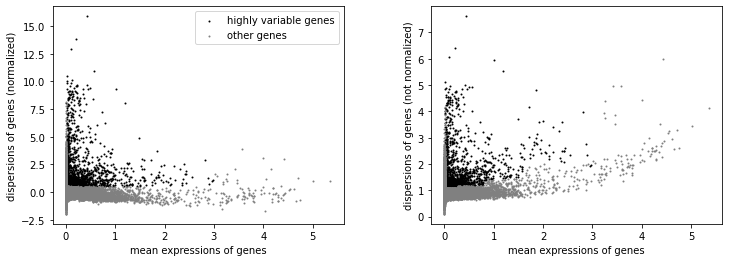

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

**Filter the genes to only those marked as highly-variable**

In [23]:
adata = adata[:, adata.var.highly_variable]

**Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.**

In [24]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical


**Run PCA**

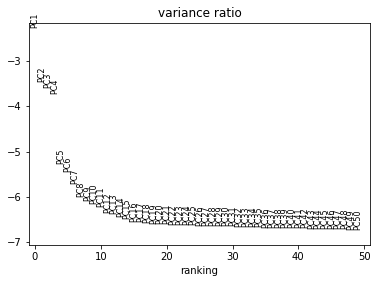

In [25]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

**Computing the neighborhood graph, umap and clusters**

In [26]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

**Visualizing the clusters and whether or not there's a corresponding contig**.

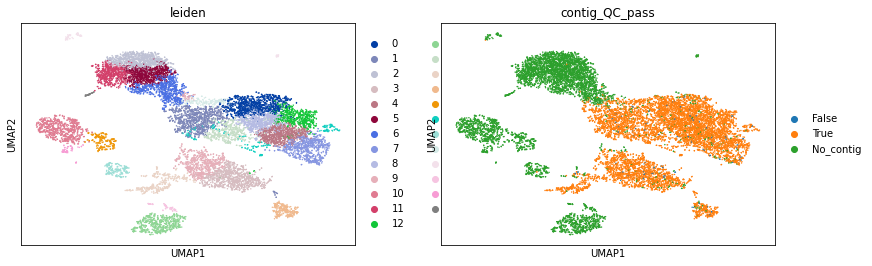

In [27]:
sc.pl.umap(adata, color=['leiden', 'contig_QC_pass'])

**Visualizing some T cell genes.**

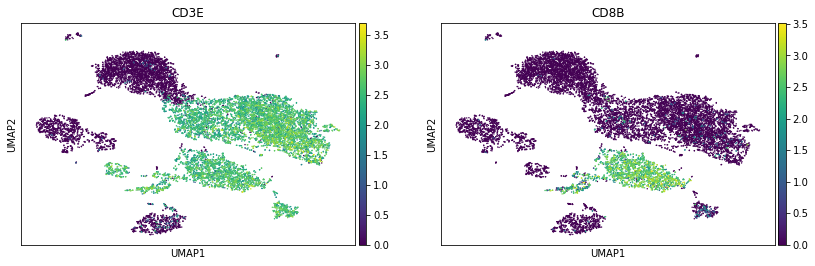

In [28]:
sc.pl.umap(adata, color=['CD3E', 'CD8B'])

**Find clones.**

Here we specify `identity = 1` so only cells with identical CDR3 amino acid sequences are grouped into clones/clonotypes. Also specify `locus = 'tr-ab` so that `dandelion` knows how to initialise the TCR data.

In [29]:
ddl.tl.find_clones(vdj, identity = 1, locus = 'tr-ab')
vdj

Finding clones based on VDJ chains : 100%|██████████| 501/501 [00:00<00:00, 2500.19it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 8468/8468 [00:00<00:00, 454104.97it/s]


Dandelion class object with n_obs = 8468 and n_contigs = 16109
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'np1_length', 'np2_length', 'multi_chain', 'high_confidence', 'umi_count'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VJ_0', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_sum

**Generate TCR network.**

Because of how I stitched together the 3 formats of the V(D)J data, some file types do not come with full `sequence_alignment_aa` or `sequence_alignment` columns. Thus, I will use `key = 'junction_aa'` which is the amino acid sequence of just the CDR3 junction.

In [30]:
ddl.tl.generate_network(vdj, key = 'junction_aa', locus = 'tr-ab')

Linking edges : 100%|██████████| 4593/4593 [04:02<00:00, 18.96it/s] 


generating network layout


In [31]:
vdj

Dandelion class object with n_obs = 8468 and n_contigs = 16109
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'np1_length', 'np2_length', 'multi_chain', 'high_confidence', 'umi_count'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VJ_0', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_sum

**Plotting in `scanpy`.**

In [41]:
ddl.tl.transfer(adata, vdj) # this will include singletons. To show only expanded clones, specify expanded_only=True

converting matrices
Updating anndata slots


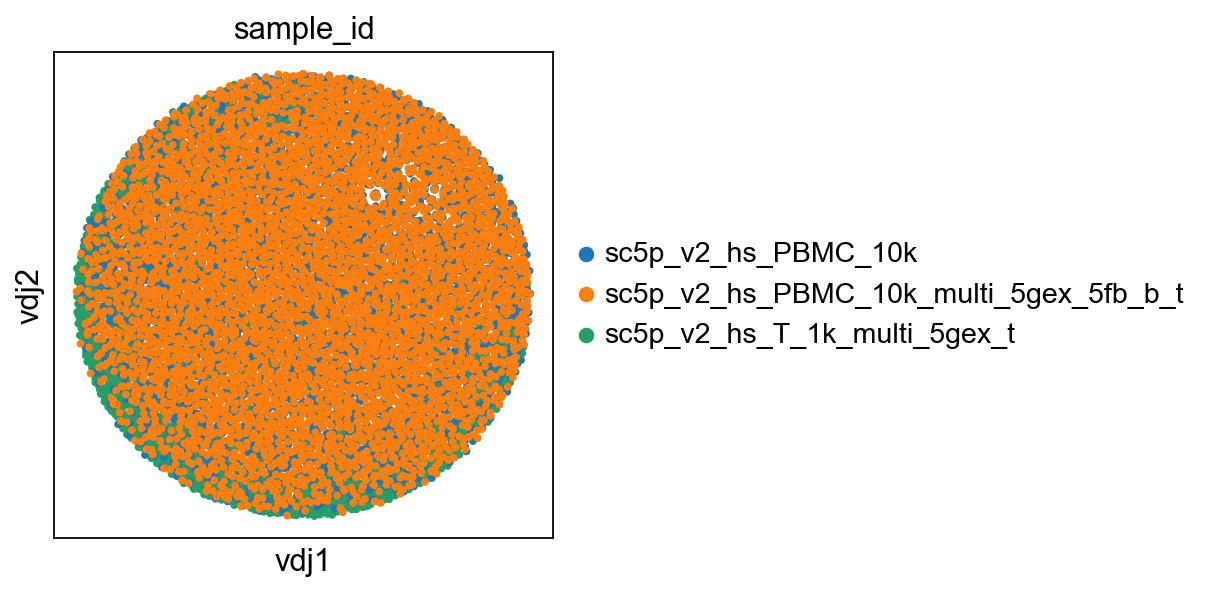

In [42]:
sc.set_figure_params(figsize = [4,4])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1,
                     size = 50) 

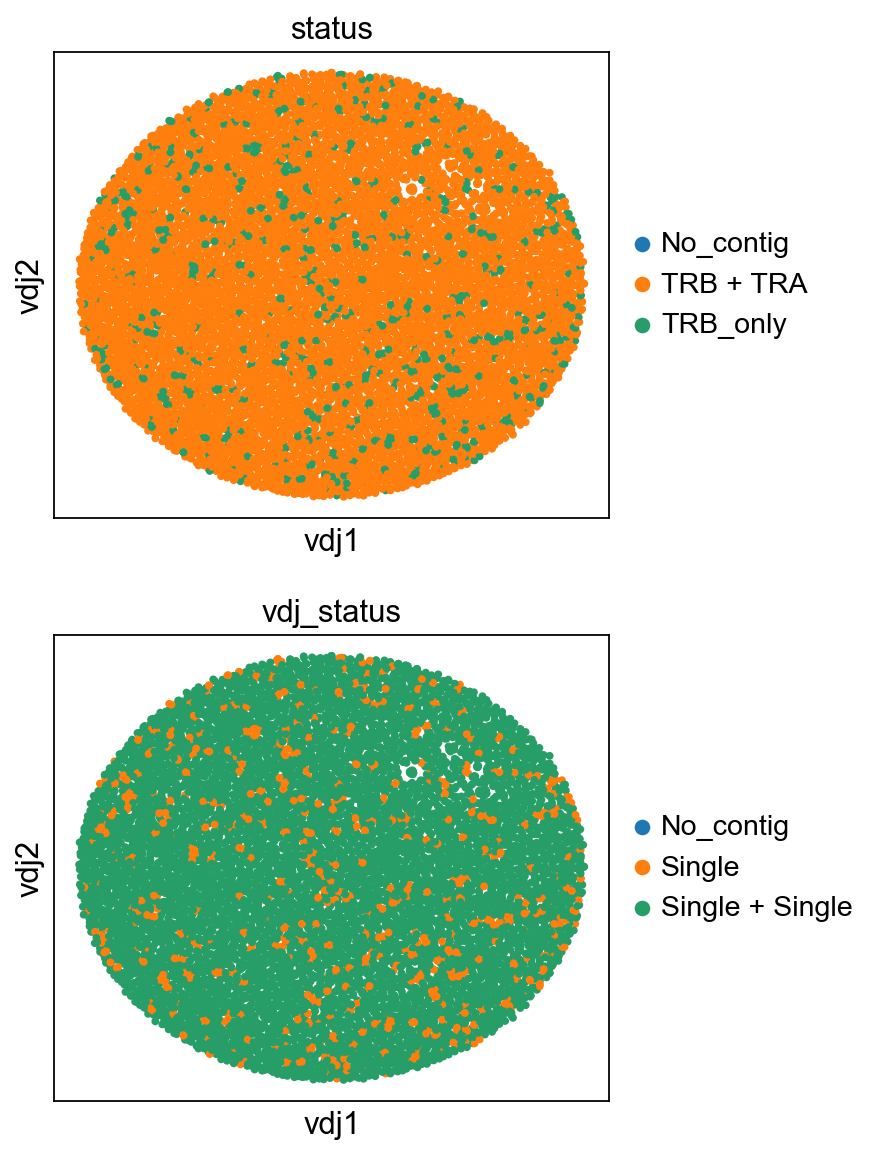

In [43]:
sc.set_figure_params(figsize = [4,4])
ddl.pl.clone_network(adata, color = ['status', 'vdj_status'], ncols = 1, legend_fontoutline=3, edges_width = 1, size = 50)

**Finish.**

We can save the files.

In [35]:
adata.write('adata_tcr.h5ad', compression = 'gzip')

In [36]:
vdj.write_h5('dandelion_results_tcr.h5', complib = 'bzip2')